# Double Gyre

* ### The dynamical system

The driven Double Gyre system is defined by the _stream function_

$$\psi (x,y,t) = A\sin(\pi f(x,t))\sin(\pi y)$$

where 

$f(x,t) = a(t) x^2 + b(t)x,$

$a(t) = \eta \sin(\omega t),$

$b(t) = 1-2 a(t)$,

over the domain  $ \Omega = [0, 2]\times[0, 1]$.
The usual parameter values are
$A = 0.1$ $\epsilon = 0.1$ and $\omega = \pi/5$. 

In [1]:
import numpy as np
from scipy.integrate import odeint

def a(t):
    return epsilon*np.sin(omega*t)

def b(t):
    return 1-2*epsilon*np.sin(omega*t)

def f(x,t):
    return a(t)*x**2+b(t)*x

def double_gyre(X, t):
    x,y = X
    vx = -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)
    vy =  np.pi*A*np.cos(np.pi*f(x,t))*np.sin(np.pi*y)*(2*a(t)*x+b(t))
    return np.array([vx,vy])

In [2]:
# parameters
A    = 0.1
epsilon  = 0.1
omega = np.pi/5

#time sample
n = 2000
tmax = 400
times = np.linspace(0, tmax, n)

def simulate_Double_Gyre(x0, y0, tmax, n):
    t = times
    f = odeint(double_gyre, (x0, y0), t)
    x, y = f.T
    return x,y

### Dependence on initial conditions

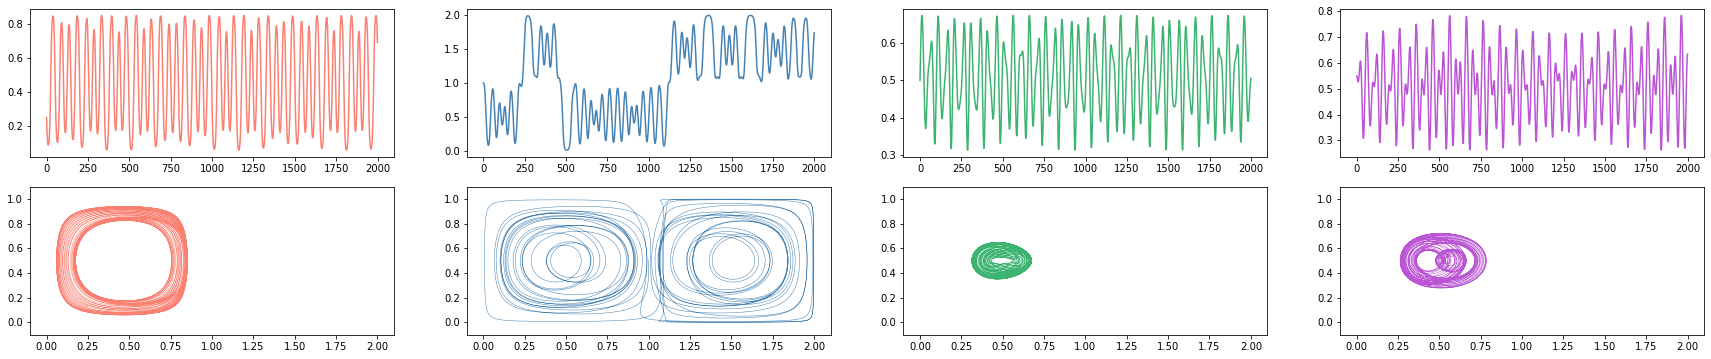

In [14]:
import pylab as plt

# initial conditions
P = [(0.25, 0.125), (1, 0.5), (0.5, 0.625), (0.55, 0.5)]
col = ['salmon','steelblue','mediumseagreen', 'mediumorchid']
x = []
y = []

fig = plt.figure(figsize=(30,6))
for i in range(len(P)):
    X,Y = simulate_Double_Gyre(P[i][0], P[i][1], tmax, n)
    x.append(X)
    y.append(Y)
    ax1 = fig.add_subplot(241+i)
    ax1.plot(x[i], c = col[i])
    ax2 = fig.add_subplot(245+i)
    ax2.set_xlim(-0.1,2.1)
    ax2.set_ylim(-0.1,1.1)
    ax2.plot(x[i], y[i], linewidth = 0.5, c = col[i])

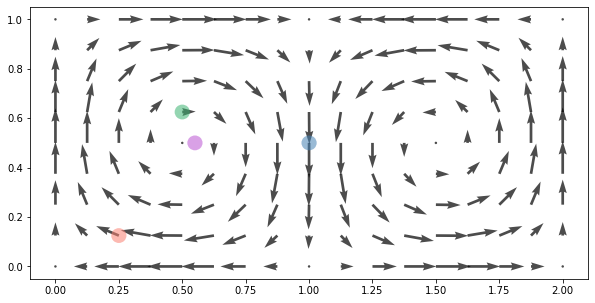

In [15]:
import matplotlib.animation as animation

partition = 8
N = int(len(P))

fig, ax = plt.subplots(1,1,figsize=(10,5))
#ax.axis('off')

# make a 2D mesh grid of size 2*partition x partition
X, Y = plt.meshgrid(np.arange(0, 2+1/partition, 1/partition), np.arange(0, 1+1/partition, 1/partition))
vX, vY = double_gyre((X,Y), 0.1)

# vector arrows
Q = ax.quiver(X, Y, vX, vY, scale=5, alpha=0.7)

# initialize array of particles
C = np.empty([N],plt.Circle)
for i in range(0,N):
    C[i] = plt.Circle((-1,-1), radius = 0.03, fc = col[i], alpha=0.55)

for i in range(0,N):
    C[i].center = (P[i][0], P[i][1])
    ax.add_patch(C[i])

# animation for particle moving along the vector field
def animate(t, Q, X, Y, C, N):
    
    vX,vY = double_gyre((X,Y),t)
    Q.set_UVC(vX,vY)  
    
    # update particles' positions
    for i in range(0,N):
        idx = np.argwhere(times > t)[0]
        C[i].center = (x[i][idx], y[i][idx])        

    return Q,C

ani = animation.FuncAnimation(fig, animate,
         fargs=(Q,X,Y,C,N),
         interval=1,blit=False,
         frames=np.linspace(0, 390, 2000))

plt.show()

In [68]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)

ani.save('figures/animation_double_gyre.mp4', writer = writer, dpi=150)

In [7]:
ani.save('figures/animation_double_gyre.gif', writer = 'pillow')

* ### Takens' Delay Embedding

In [4]:
def delay_embedding(s, T, d, step=1):
    '''
    Delay embedding of a time series
    
    INPUT:
    - s: 1-dimensional array, the time series.
    - T: an integer, the delay
    - d: an integer, the ambient dimension of the embedding
    - step: an integer, the step used to read the time series
    
    OUTPUT: an array, representing points in R^d
    '''
    
    N = len(s)
    X = []
    for i in range(d):
        X.append(s[i*T: N-(d-1-i)*T:step])
    return np.stack(X).T

In [5]:
T = int(2*np.pi/omega)
d = 4
embedding = []
for i in range(len(P)):
    embedding.append(delay_embedding(x[i], T, d, step=1))

We next visualize the projection to the first three coordinates of the time-delay embedding of the signal $x$ of the fluid flow for the different initial conditions.

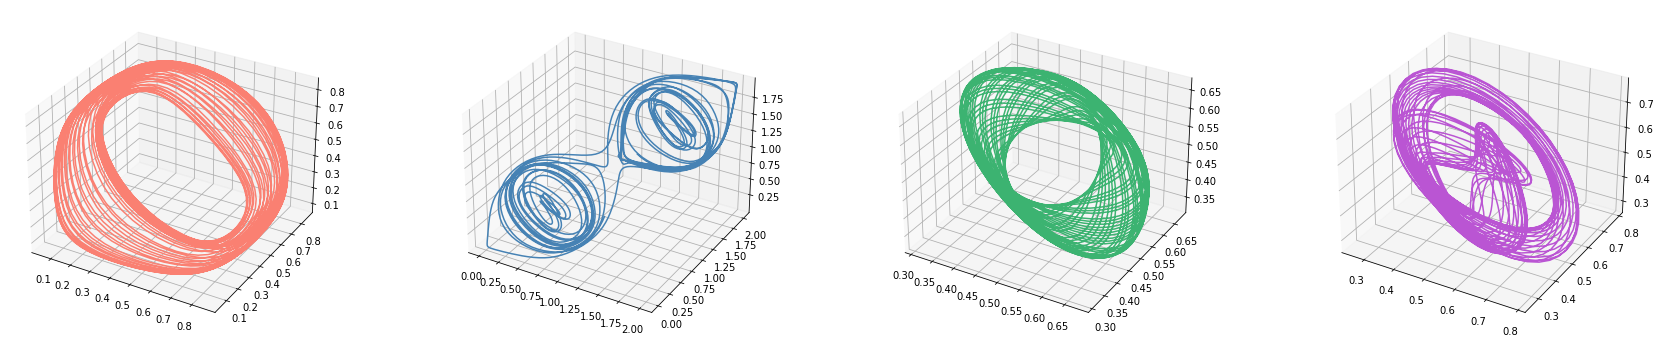

In [16]:
fig = plt.figure(figsize=(30,6))
for i in range(len(P)):
    X,Y = simulate_Double_Gyre(P[i][0], P[i][1], tmax, n)
    x.append(X)
    y.append(Y)
    ax = fig.add_subplot(141+i, projection='3d')
    ax.plot(embedding[i][:,0], embedding[i][:,1], embedding[i][:,2], c = col[i])

* ### Persistent Homology

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Initial condition (0.25, 0.125)


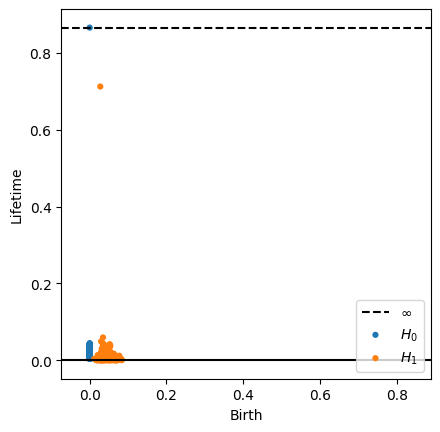

Initial condition (1, 0.5)


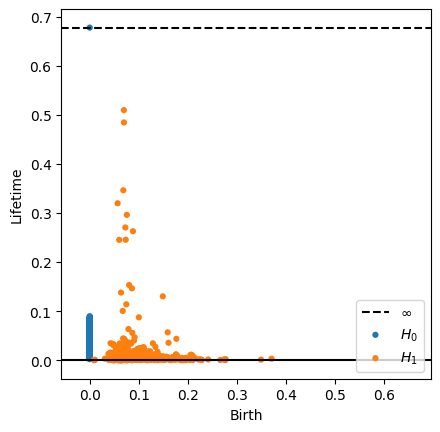

Initial condition (0.5, 0.625)


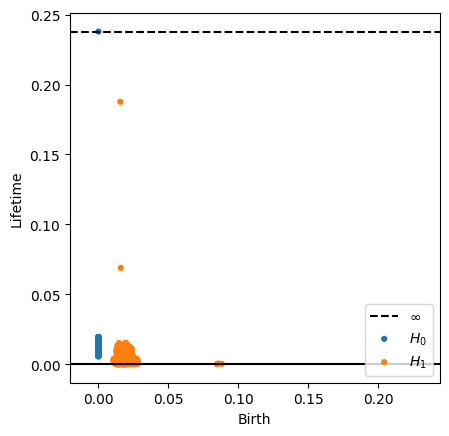

Initial condition (0.55, 0.5)


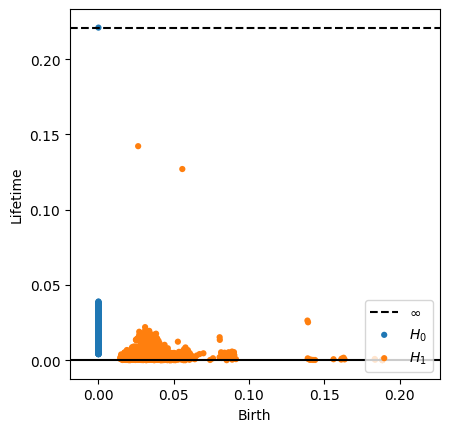

In [18]:
from ripser import Rips

rips = Rips(maxdim = 1)
for i in range(4):
    dgms = rips.fit_transform(embedding[i])
    rips.plot(dgms, lifetime=True)
    print('Initial condition', P[i])
    plt.show()